<a href="https://colab.research.google.com/github/vi1801/Sentiment_Analysis/blob/main/IMDB_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Sentiment Analysis using NLTK

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re

plt.style.use('ggplot')

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Data/IMDB Dataset.csv')

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df['review'].values[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [7]:
print(df.shape)

(50000, 2)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


###Quick EDA

Text(0.5, 1.0, 'Sentiment Distribution')

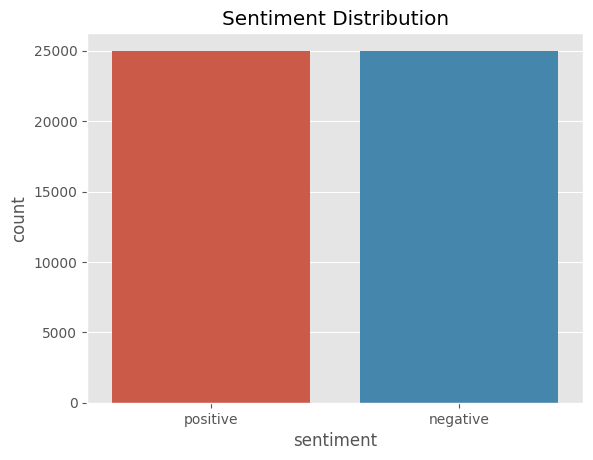

In [9]:
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution")

In [10]:
for i in range(5):
  print("review: ",[i])
  print(df['review'].iloc[i], "\n")
  print("Sentiment: ", df['sentiment'].iloc[i],"\n\n")

review:  [0]
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

In [11]:
def no_of_words(text):
  words = text.split()
  word_count = len(words)
  return word_count

In [12]:
df['word count'] = df['review'].apply(no_of_words)

In [13]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,positive,307
1,A wonderful little production. <br /><br />The...,positive,162
2,I thought this was a wonderful way to spend ti...,positive,166
3,Basically there's a family where a little boy ...,negative,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230


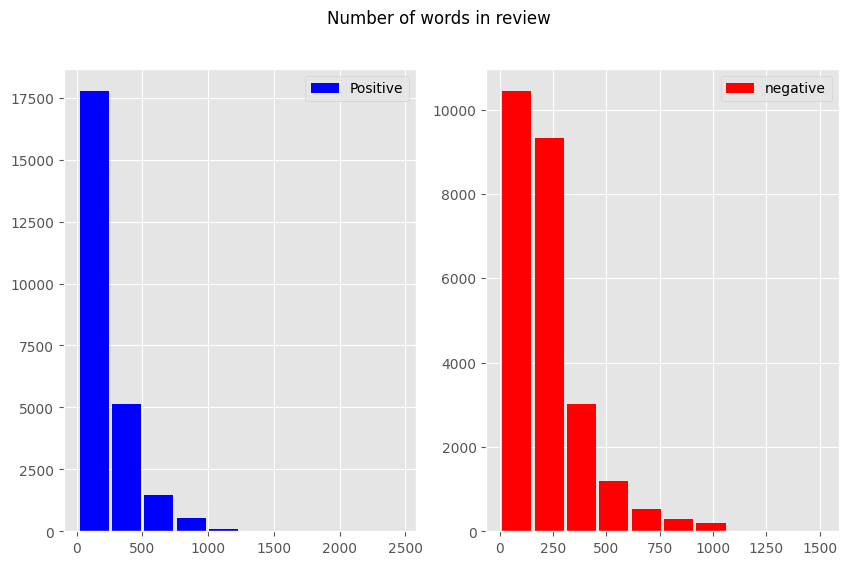

In [14]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['word count'], label='Positive', color = 'blue', rwidth=0.9);
ax[0].legend(loc='upper right')
ax[1].hist(df[df['sentiment'] == 'negative']['word count'], label='negative', color = 'red', rwidth=0.9);
ax[1].legend(loc='upper right')
fig.suptitle("Number of words in review")
plt.show()

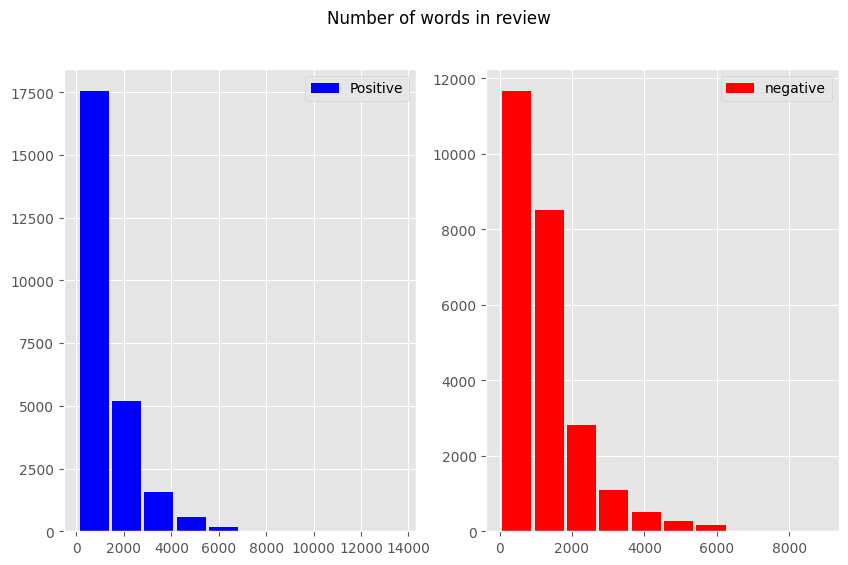

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].hist(df[df['sentiment'] == 'positive']['review'].str.len(), label='Positive', color = 'blue', rwidth=0.9);
ax[0].legend(loc='upper right')
ax[1].hist(df[df['sentiment'] == 'negative']['review'].str.len(), label='negative', color = 'red', rwidth=0.9);
ax[1].legend(loc='upper right')
fig.suptitle("Number of words in review")
plt.show()

In [16]:
df.sentiment.replace("positive", 1, inplace=True)
df.sentiment.replace("negative", 0, inplace=True)

In [17]:
df.head()

,review,sentiment,word count
0,One of the other reviewers has mentioned that ...,1,307
1,A wonderful little production. <br /><br />The...,1,162
2,I thought this was a wonderful way to spend ti...,1,166
3,Basically there's a family where a little boy ...,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,230


###Preprocessing text

In [18]:
def data_processing(text):
  text = text.lower()
  text = re.sub('<br />', '', text) # removes break tags
  text = re.sub(r"https\S+|www\S+|http\S+", '', text,flags = re.MULTILINE) # removes links
  text = re.sub(r'\@w+|\#','', text) # removes +,#
  text = re.sub(r'[^\w\s]','', text) # removes punctuations
  text_tokens = word_tokenize(text)
  filtered_text = [w for w in text_tokens if not w in stop_words]
  return " ".join(filtered_text)

In [19]:
df.review = df['review'].apply(data_processing)

In [20]:
df.head()

,review,sentiment,word count
0,one reviewers mentioned watching 1 oz episode ...,1,307
1,wonderful little production filming technique ...,1,162
2,thought wonderful way spend time hot summer we...,1,166
3,basically theres family little boy jake thinks...,0,138
4,petter matteis love time money visually stunni...,1,230


In [21]:
duplicated_count = df.duplicated().sum()
print("duplicated data: ", duplicated_count)

duplicated data:  421


In [22]:
df = df.drop_duplicates('review')

### Stemming data

In [23]:
stemmer = PorterStemmer()
def stemming(data):
  text = [stemmer.stem(word) for word in data]
  return data

In [24]:
df.review = df['review'].apply(lambda x: stemming(x))

In [25]:
df['word count'] = df['review'].apply(no_of_words)
df.head()

,review,sentiment,word count
0,one reviewers mentioned watching 1 oz episode ...,1,168
1,wonderful little production filming technique ...,1,84
2,thought wonderful way spend time hot summer we...,1,86
3,basically theres family little boy jake thinks...,0,67
4,petter matteis love time money visually stunni...,1,125


In [26]:
pos_reviews = df[df.sentiment == 1]
pos_reviews.head()

,review,sentiment,word count
0,one reviewers mentioned watching 1 oz episode ...,1,168
1,wonderful little production filming technique ...,1,84
2,thought wonderful way spend time hot summer we...,1,86
4,petter matteis love time money visually stunni...,1,125
5,probably alltime favorite movie story selfless...,1,58


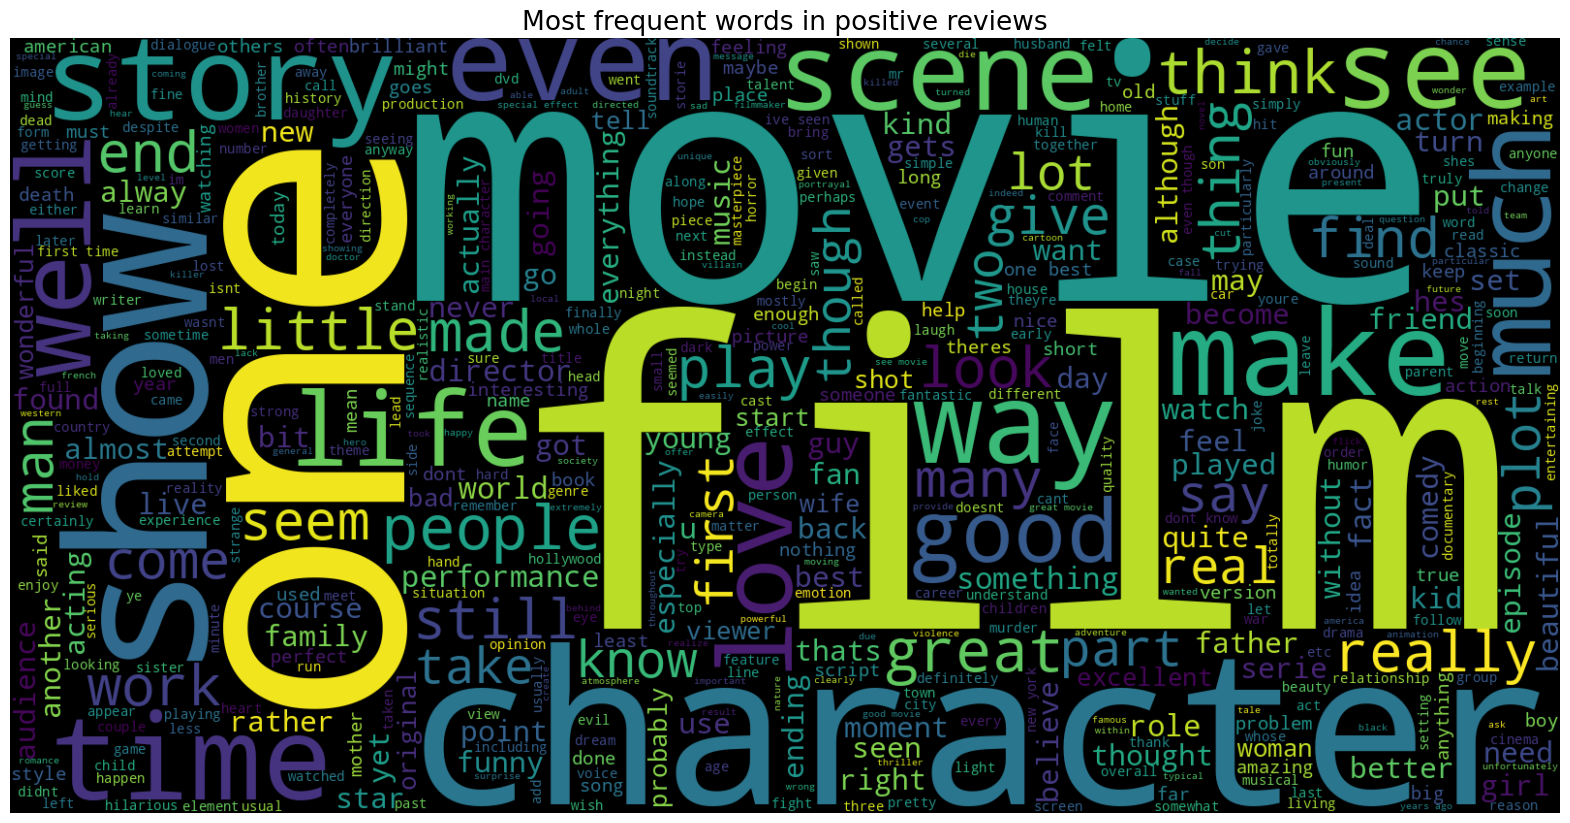

In [27]:
text = ' '.join([word for word in pos_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in positive reviews", fontsize  =19)
plt.show()

In [28]:
from collections import Counter
count = Counter()
for text in pos_reviews['review'].values:
  for word in text.split():
    count[word] += 1
count.most_common(15)

[('film', 39285),
 ('movie', 35830),
 ('one', 25621),
 ('like', 16998),
 ('good', 14281),
 ('great', 12568),
 ('story', 12338),
 ('see', 11814),
 ('time', 11724),
 ('well', 10930),
 ('really', 10638),
 ('also', 10516),
 ('would', 10320),
 ('even', 9318),
 ('much', 8971)]

In [29]:
pos_words = pd.DataFrame(count.most_common(15))
pos_words.columns = ['word', 'count']
pos_words.head()

,word,count
0,film,39285
1,movie,35830
2,one,25621
3,like,16998
4,good,14281


In [30]:
px.bar(pos_words, x='count', y='word', title='Common words in positive reviews', color = 'word')

In [31]:
neg_reviews = df[df.sentiment == 0]
neg_reviews.head()

,review,sentiment,word count
3,basically theres family little boy jake thinks...,0,67
7,show amazing fresh innovative idea 70s first a...,0,83
8,encouraged positive comments film looking forw...,0,64
10,phil alien one quirky films humour based aroun...,0,51
11,saw movie 12 came recall scariest scene big bi...,0,84


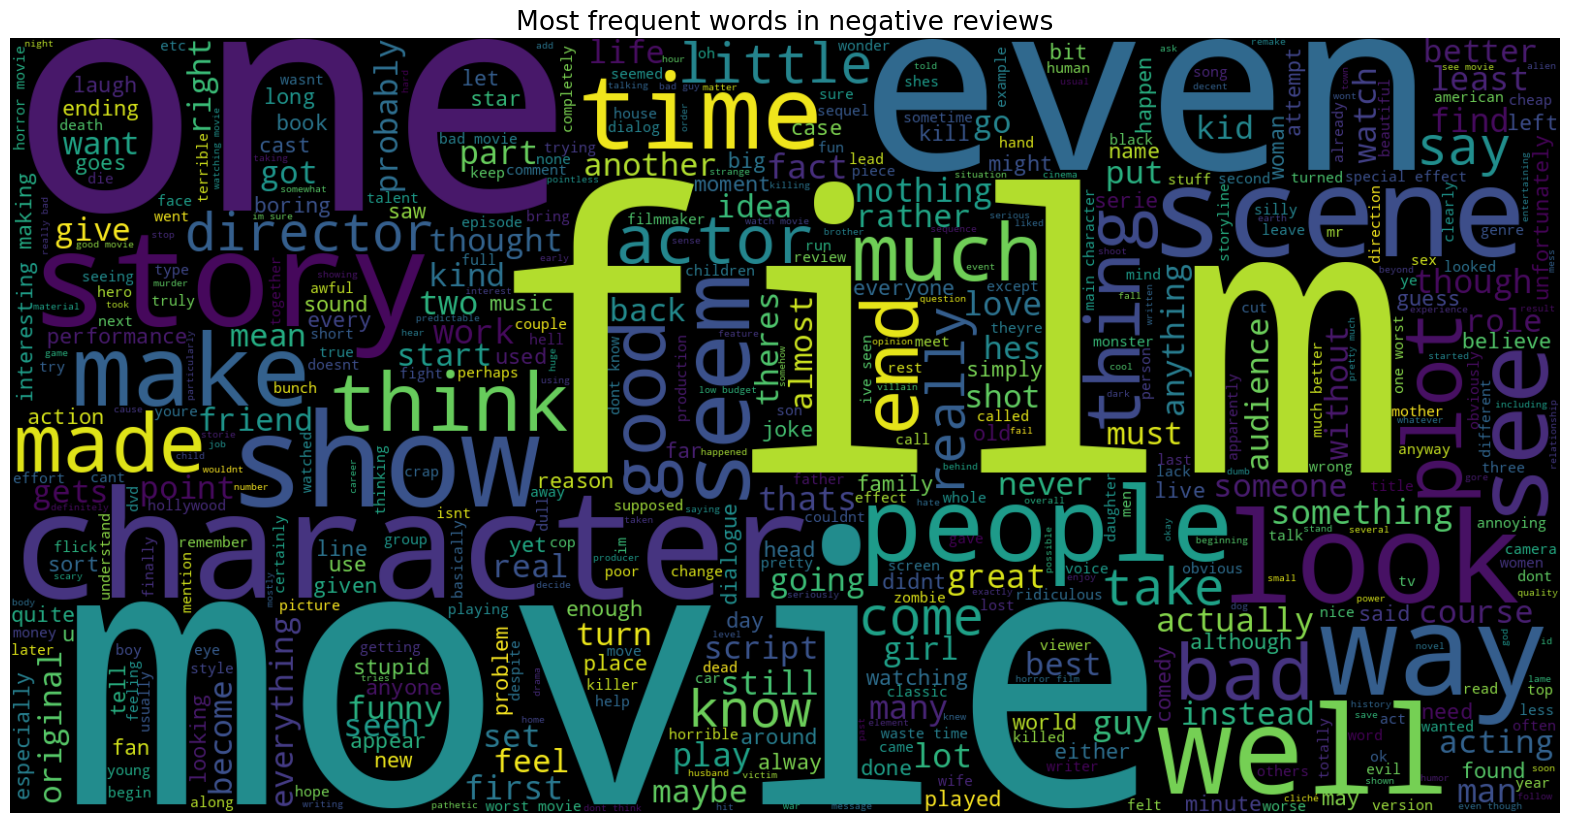

In [32]:
text = ' '.join([word for word in neg_reviews['review']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most frequent words in negative reviews", fontsize  =19)
plt.show()

In [33]:
from collections import Counter
count = Counter()
for text in neg_reviews['review'].values:
  for word in text.split():
    count[word] += 1
count.most_common(15)

[('movie', 47001),
 ('film', 34651),
 ('one', 24361),
 ('like', 21508),
 ('even', 14759),
 ('good', 13995),
 ('bad', 13903),
 ('would', 13482),
 ('really', 12084),
 ('time', 11349),
 ('see', 10412),
 ('dont', 9912),
 ('get', 9884),
 ('much', 9758),
 ('story', 9563)]

In [34]:
neg_words = pd.DataFrame(count.most_common(15))
neg_words.columns = ['word', 'count']
neg_words.head()

,word,count
0,movie,47001
1,film,34651
2,one,24361
3,like,21508
4,even,14759


In [35]:
px.bar(neg_words, x='count', y='word', title='Common words in negative reviews', color = 'word')

In [36]:
X = df['review']
y = df['sentiment']

In [37]:
vect = TfidfVectorizer()
X = vect.fit_transform(df['review'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
print("Size of X_train: ", (X_train.shape))
print("Size of X_test: ", (X_test.shape))
print("Size of y_train: ", (y_train.shape))
print("Size of y_test: ", (y_test.shape))

Size of X_train:  (34704, 221707)
Size of X_test:  (14874, 221707)
Size of y_train:  (34704,)
Size of y_test:  (14874,)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [41]:
lo = LogisticRegression()
lo.fit(X_train, y_train)
lo_pred = lo.predict(X_test)
lo_acc = accuracy_score(lo_pred, y_test)
print("Test Accuracy: {:.2f}%".format(lo_acc*100))

Test Accuracy: 89.00%


In [42]:
print(confusion_matrix(y_test, lo_pred))
print("\n")
print(classification_report(y_test, lo_pred))

[[6453  908]
 [ 728 6785]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7361
           1       0.88      0.90      0.89      7513

    accuracy                           0.89     14874
   macro avg       0.89      0.89      0.89     14874
weighted avg       0.89      0.89      0.89     14874



In [43]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)
mnb_acc = accuracy_score(mnb_pred, y_test)
print("Test Accuracy: {:.2f}%".format(mnb_acc*100))

Test Accuracy: 86.44%


In [44]:
print(confusion_matrix(y_test, mnb_pred))
print("\n")
print(classification_report(y_test, mnb_pred))

[[6418  943]
 [1074 6439]]


              precision    recall  f1-score   support

           0       0.86      0.87      0.86      7361
           1       0.87      0.86      0.86      7513

    accuracy                           0.86     14874
   macro avg       0.86      0.86      0.86     14874
weighted avg       0.86      0.86      0.86     14874



In [45]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test Accuracy: {:.2f}%".format(svc_acc*100))

Test Accuracy: 89.22%


In [46]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[6504  857]
 [ 747 6766]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7361
           1       0.89      0.90      0.89      7513

    accuracy                           0.89     14874
   macro avg       0.89      0.89      0.89     14874
weighted avg       0.89      0.89      0.89     14874



In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100], 'loss':['hinge', 'squared_hinge']}
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................C=0.1, loss=hinge;, score=0.872 total time=   0.5s
[CV 2/5] END .................C=0.1, loss=hinge;, score=0.875 total time=   0.6s
[CV 3/5] END .................C=0.1, loss=hinge;, score=0.871 total time=   0.6s
[CV 4/5] END .................C=0.1, loss=hinge;, score=0.878 total time=   0.6s
[CV 5/5] END .................C=0.1, loss=hinge;, score=0.874 total time=   1.1s
[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.892 total time=   1.0s
[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.895 total time=   1.0s
[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.888 total time=   0.6s
[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.894 total time=   0.5s
[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.890 total time=   0.5s
[CV 1/5] END ...................C=1, loss=hinge;, score=0.896 total time=   0.7s
[CV 2/5] END ...................C=1, loss=hinge;,

GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [48]:
print("best cross validation score: {:.2f}".format(grid.best_score_))
print("best parameters: ", grid.best_score_)

best cross validation score: 0.89
best parameters:  0.893989176787306


In [49]:
svc = LinearSVC(C=1, loss = 'hinge')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("Test Accuracy: {:.2f}%".format(svc_acc*100))

Test Accuracy: 89.41%


In [50]:
print(confusion_matrix(y_test, lo_pred))
print("\n")
print(classification_report(y_test, lo_pred))

[[6453  908]
 [ 728 6785]]


              precision    recall  f1-score   support

           0       0.90      0.88      0.89      7361
           1       0.88      0.90      0.89      7513

    accuracy                           0.89     14874
   macro avg       0.89      0.89      0.89     14874
weighted avg       0.89      0.89      0.89     14874

